In [ ]:
# Check the full Power BI report here:

https://app.powerbi.com/view?r=eyJrIjoiZmQwMGZkNWQtOWU1YS00ZDllLWIwNTYtZWZmMzNkMzBjYzYyIiwidCI6ImIzYmNlMTdhLWZhYzktNDEwYS1iMWI1LTMyYmJkM2UwMTVmNSIsImMiOjh9

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_rows', None)

In [4]:
# import dataset in a pandas df 

url = r"C:\Users\tugno\OneDrive\Projects\Okc\shots_data.csv"

df = pd.read_csv(url)
df.shape

(504, 4)

In [6]:
# check for nulls

df.isnull().sum()

team      0
x         0
y         0
fgmade    0
dtype: int64

In [7]:
# add a column to the df with the distance between the location of the shot (x,y) and the hoop (0,0)

df['d'] = np.sqrt(np.power((df['x']), 2)+(np.power((df['y']), 2)))
df.sample(10)

,team,x,y,fgmade,d
70,Team A,0.5,18.0,0,18.006943
370,Team B,-2.8,1.1,0,3.008322
127,Team A,-0.6,0.9,1,1.081665
401,Team B,9.2,23.4,0,25.143588
41,Team A,-0.2,0.5,1,0.538516
475,Team B,-1.6,8.7,0,8.845903
72,Team A,-18.3,2.0,0,18.408965
279,Team A,2.4,6.6,1,7.022820
306,Team B,5.1,20.4,0,21.027839
215,Team A,1.3,0.9,1,1.581139


In [8]:
# add a column to the df with the zone name

conditions = [
    ((df['d']>22) & (df['y']<7.8)),
    ((df['d']>23.75) & (df['y']>7.8))
]
choices = ['3 Points Corners', '3 Points (No Corners)']
df['zone'] = np.select(conditions, choices, default='2 Points')
df.head()

,team,x,y,fgmade,d,zone
0,Team A,-5.0,26.4,0,26.869313,3 Points (No Corners)
1,Team A,-0.8,1.2,1,1.442221,2 Points
2,Team A,-13.9,9.5,1,16.836270,2 Points
3,Team A,-5.4,26.2,0,26.750701,3 Points (No Corners)
4,Team A,-4.9,14.5,1,15.305555,2 Points


In [9]:
# create df for 3 pts corners shots

df_C3 = df[(df['d']>22) & (df['y']<7.8)]

In [10]:
# create df for 3 pts shots (no corners)
df_NC3 = df[(df['d']>23.75) & (df['y']>7.8)]


In [11]:
# create df for 2 pts shots

test1 = df[(df['d']<23.75) & (df['y']>7.8)]
test2 = df[(df['x'].between(-22, 22)) & (df['y']<7.8)]
frames = [test1, test2]
df_PT2 = pd.concat(frames)

In [12]:
# function shots analysis

def show_court_chart(pddf, sel):
    """This function accepts two arguments: df of the shots zone and team. 
    
    pddf: it returns the chart of the shots of three zones:
            1) df_PT2 -> returns the 2 pts shots
            2) df_NC3 -> returns the 3 pts shots not from the corners
            3) df_C3 -> returns the 3 pts shots from the corners
    
    sel: select a team:
            1) 'A'
            2) 'B'
    """
    # variables assignments
    team = 'Team ' + str(sel)
    dfuser = pddf[pddf['team']==team]
    dfuser_missed = dfuser[dfuser['fgmade']==0]
    dfuser_made = dfuser[dfuser['fgmade']==1]

    FGM = pddf[pddf['team']==team]['fgmade']
    FGA = FGM.count()
    three_PM_NC3 = dfuser[(dfuser['d']>23.75) & (dfuser['y']>7.8)]['fgmade'].sum()
    three_PM_C3 = dfuser[(dfuser['d']>22) & (dfuser['y']<7.8)]['fgmade'].sum()

    # function to get the name of a df
    def get_df_name(DataFrame):
        name =[x for x in globals() if globals()[x] is DataFrame][0]
        return name

    # function to create basketball court
    def create_court(ax, color):
        ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
        ax.plot([220, 220], [0, 140], linewidth=2, color=color)

        ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))

        ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
        ax.plot([80, 80], [0, 190], linewidth=2, color=color)
        ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
        ax.plot([60, 60], [0, 190], linewidth=2, color=color)
        ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
        ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))

        ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

        ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_xlim(-250, 250)
        ax.set_ylim(0, 470)
    
    # creation of the court
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    ax = create_court(ax, 'black')
    
    # representing of the shots
    plt.scatter(dfuser_missed['x']*10, dfuser_missed['y']*10+60, marker='x', s=300, linewidths=3, c='r')
    plt.scatter(dfuser_made['x']*10, dfuser_made['y']*10+60, marker='o', s=100, linewidths=3, c='g')

    # if condition for the eFG% calculation
    if get_df_name(pddf) == 'df_PT2':
        eFG_pct = round(((FGM.sum())+(0.5*0))/(FGM.count())*100, 3)
        zone = '2 Points'
    elif get_df_name(pddf) == 'df_NC3':
        eFG_pct = round(((FGM.sum())+(0.5*three_PM_NC3))/(FGM.count())*100, 3)
        zone = '3 Points (no corners)'
    elif get_df_name(pddf) == 'df_C3':
        eFG_pct = round(((FGM.sum())+(0.5*three_PM_C3))/(FGM.count())*100, 3)
        zone = '3 Points corners'
    # FG% calculation    
    FG_pct = round((FGM.sum()/FGA)*100, 3)

    # how many shots on the total the team has taken on that zone (shot_distribution)
    tot_fg_a = df[df['team']==team]['fgmade'].count()
    shot_distribution = round((FGA/tot_fg_a)*100, 3)

    print(
        f'TEAM: {sel}\n'
        f'Effective field goal percentage in this zone ({zone}): {eFG_pct}%\n'
        f'Field goal percentage in this zone ({zone}): {FG_pct}% ({FGM.sum()}/{FGA})\n'
        f'Shot distribution in this zone ({zone}): {shot_distribution}% ({FGA}/{tot_fg_a})'
        )
    plt.show()

TEAM: B
Effective field goal percentage in this zone (3 Points (no corners)): 50.806%
Field goal percentage in this zone (3 Points (no corners)): 33.871% (21/62)
Shot distribution in this zone (3 Points (no corners)): 27.679% (62/224)


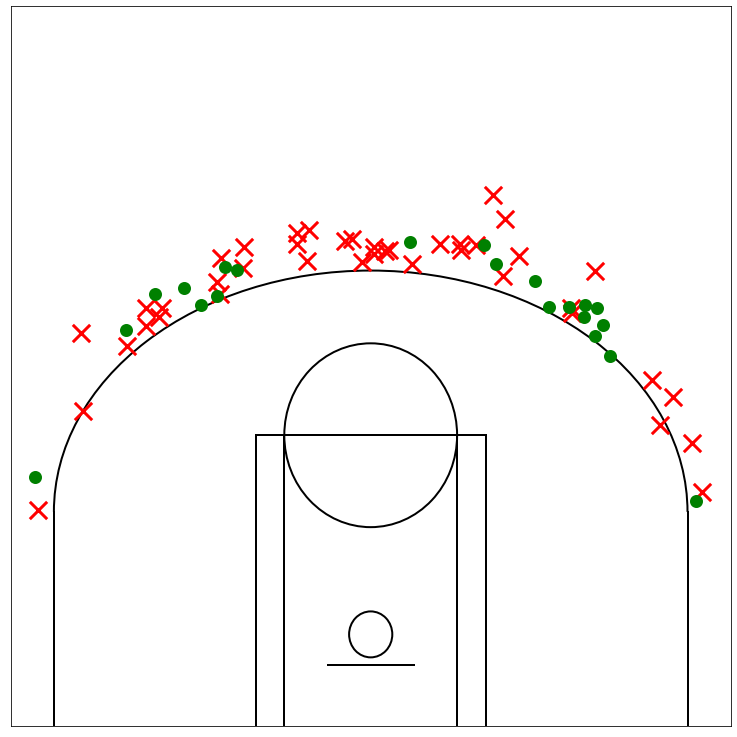

In [13]:
show_court_chart(df_NC3, 'B')

TEAM: A
Effective field goal percentage in this zone (2 Points): 48.969%
Field goal percentage in this zone (2 Points): 48.969% (95/194)
Shot distribution in this zone (2 Points): 69.286% (194/280)


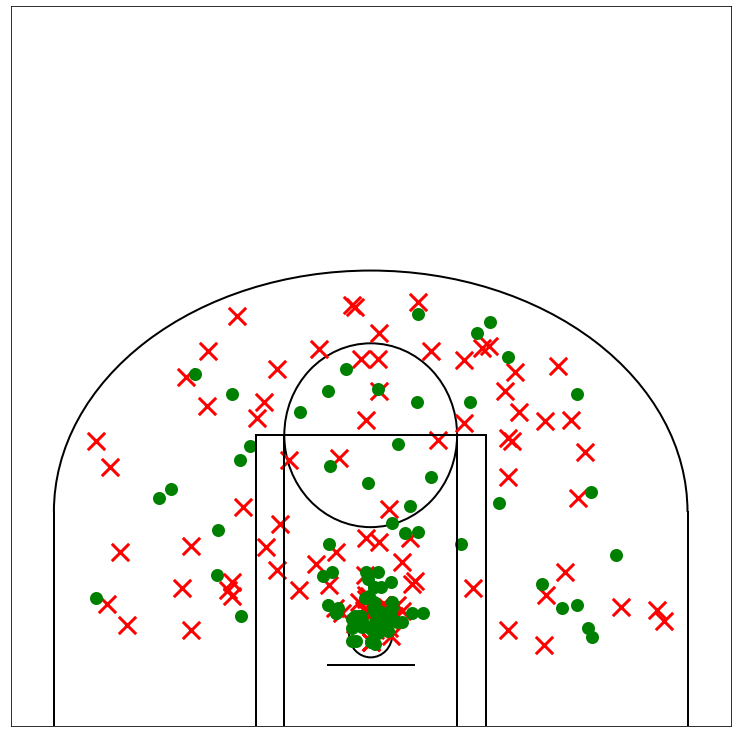

In [14]:
show_court_chart(df_PT2, 'A')

TEAM: A
Effective field goal percentage in this zone (3 Points corners): 70.588%
Field goal percentage in this zone (3 Points corners): 47.059% (8/17)
Shot distribution in this zone (3 Points corners): 6.071% (17/280)


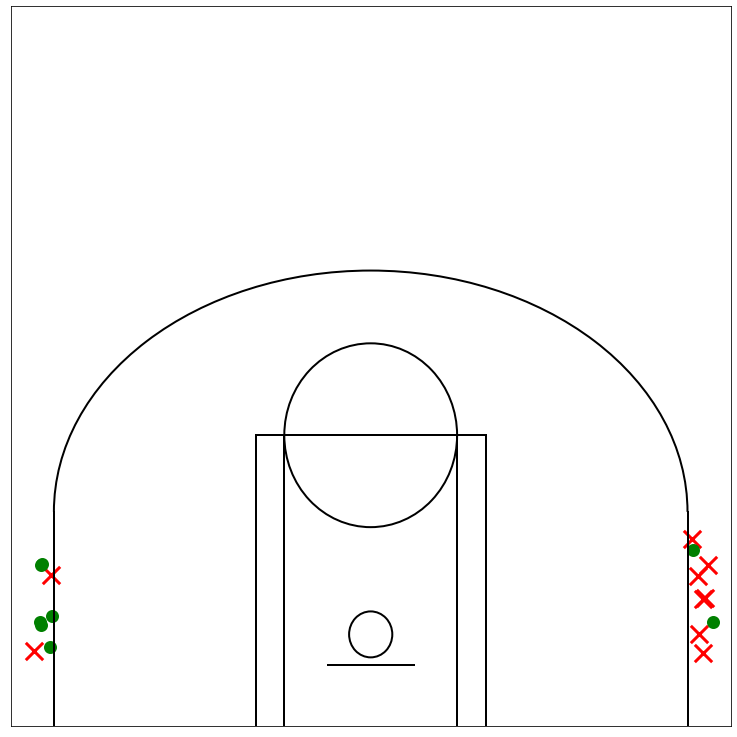

In [15]:
show_court_chart(df_C3, 'A')